**Garbage Classification**


# 1) Business Problem

Classification of solid waste
(Automating solid waste classification and transferring human labor to machines)

# 2) Data Understanding

The dataset we will use within the scope of this project is the dataset named TrashNet. The data set consists of six different classes. There are a total of 2527 images in the dataset, including glass, paper, cardboard, plastic, metal and trash.

Distribution of images:
- 501 glass
- 594 paper
- 403 cardboard
- 482 plastic
- 410 metal
- 137 trash

2.1) İmport libraries

In [1]:
# for reading and processing data
!pip install imutils

import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# for model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img


  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=87b6de6db8b0e6b161b5398608adc4f62f42dfd92961a7181e683c210c5c3222
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


2.2) Read dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
target_size = (224, 224)
waste_labels = {'cardboard': 0, 'glass':1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash':5}


In [4]:
def load_datasets(path, waste_labels, target_size):
    x = []
    labels = []

    image_paths = sorted(glob.glob(os.path.join(path, "*/*.jpg")))

    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        x.append(img)
        label = os.path.basename(os.path.dirname(image_path))
        labels.append(waste_labels[label])

    x, labels = shuffle(x, labels, random_state=42)

    print(f"X size: {np.array(x).shape}")
    print(f"Number of label classes: {len(np.unique(labels))}, Number of observations: {len(labels)}")

    return np.array(x), np.array(labels)

# Define the directory path
dir_path = '/content/drive/MyDrive/Garbage classification'

# Call the function to load datasets
x, labels = load_datasets(dir_path, waste_labels, target_size)


X size: (2527, 224, 224, 3)
Number of label classes: 6, Number of observations: 2527


In [5]:
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1],3)
print(input_shape)

(224, 224, 3)


2.3) Veri Setinden Örnekler Gösterilmesi

In [6]:
def visualize_img(image_batch, label_batch):
  plt.figure(figsize=(10, 10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
    plt.axis('off')

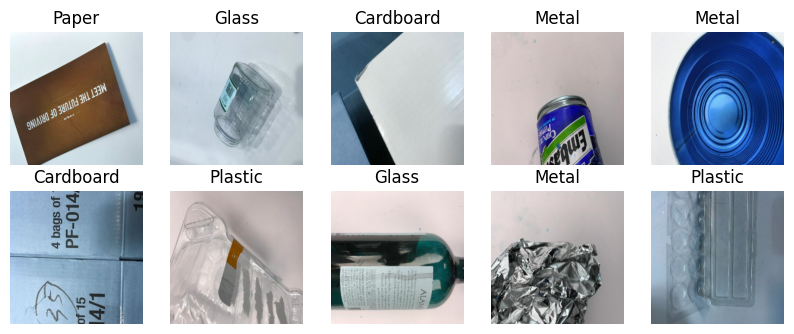

In [7]:
visualize_img(x, labels)

# 3) Data Preparation

In [8]:
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

test = ImageDataGenerator(rescale=1/255, validation_split=0.1)

In [9]:
train_generator = train.flow_from_directory(directory = dir_path,
                                            target_size = (target_size),
                                            class_mode = 'categorical',
                                            subset = 'training')

test_generator = train.flow_from_directory(directory = dir_path,
                                           target_size = (target_size),
                                           class_mode = 'categorical',
                                           subset = 'validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# 4) CNN Model

- Sequential
- Convolution Layer, Conv2D
- Pooling Layer
- Activation Layer
- Flattening Layer
- Dense Layer
- Dropout Layer



In [10]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation='softmax'))


4.2) Model Summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

4.3) Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=(tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'acc'))

In [13]:
callbacks = (EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode="min"),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode="min", save_best_only=True, save_weights_only=False, verbose=1))


4.4) Training the Model

In [14]:
history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers=4,
                              steps_per_epoch=2276//32,
                              validation_steps=251//32)

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 1.6035 - precision: 0.7363 - recall: 0.0597 - acc: 0.3191
Epoch 1: val_loss improved from inf to 1.54724, saving model to mymodel.h5
71/71 [==============================] - 30s 397ms/step - loss: 1.6035 - precision: 0.7363 - recall: 0.0597 - acc: 0.3191 - val_loss: 1.5472 - val_precision: 0.8000 - val_recall: 0.0536 - val_acc: 0.3973
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.4570 - precision: 0.7146 - recall: 0.1373 - acc: 0.3993
Epoch 2: val_loss improved from 1.54724 to 1.41959, saving model to mymodel.h5
71/71 [==============================] - 28s 387ms/step - loss: 1.4570 - precision: 0.7146 - recall: 0.1373 - acc: 0.3993 - val_loss: 1.4196 - val_precision: 0.6667 - val_recall: 0.1339 - val_acc: 0.4375
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.3821 - precision: 0.7135 - recall: 0.1720 - acc: 0.4256
Epoch 3: val_loss improved from 1.41959 to 1.41536, savin

4.5) Accuracy and Loss Charts

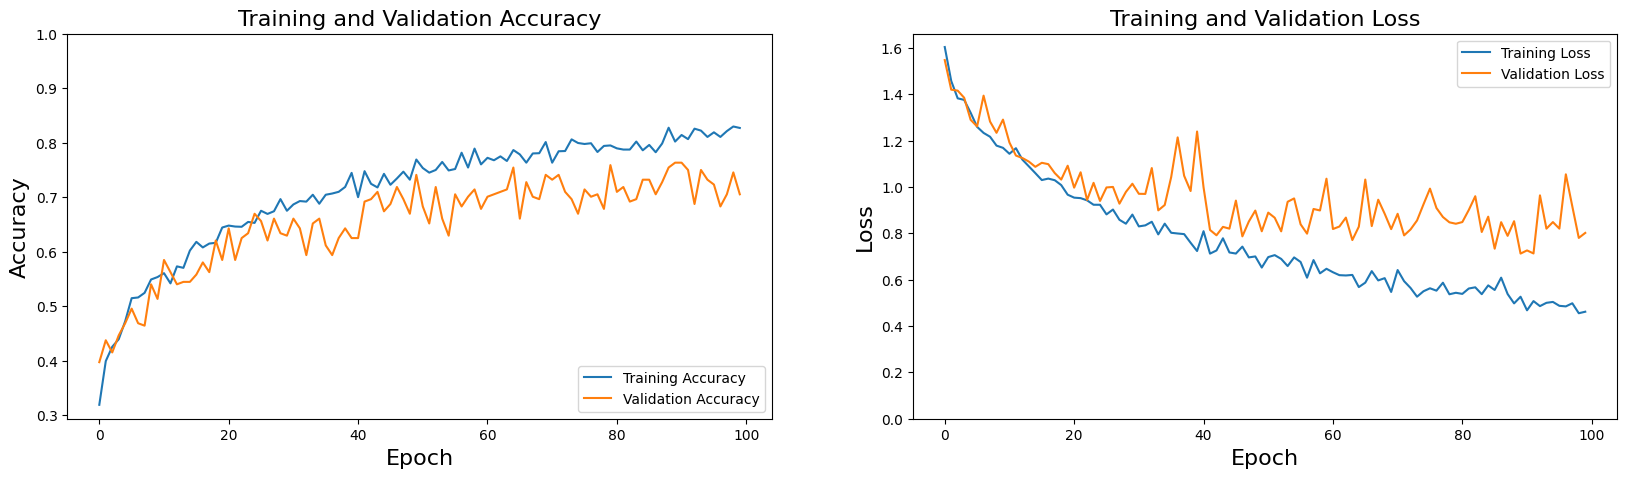

In [15]:
#################
# Accuracy Chart
#################

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history["val_acc"], label=("Validation Accuracy"))
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy", fontsize=16)

#################
# Loss Chart
#################


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history["val_loss"], label=("Validation Loss"))
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0,max(plt.ylim()),])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()

# 5) Evaluation

In [16]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

8/8 [==============================] - 3s 405ms/step - loss: 0.7910 - precision: 0.7900 - recall: 0.6892 - acc: 0.7251


In [17]:
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))
print("\nTest precision: %.1f%%" % (100.0 * precision))
print("\nTest recall: %.1f%%" % (100.0 * recall))



Test accuracy: 72.5%

Test loss: 79.1%

Test precision: 79.0%

Test recall: 68.9%


In [18]:
# Classification Report

x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)



1/1 [==============================] - 0s 178ms/step


In [19]:
target_names = list(waste_labels.keys())

In [20]:
print(classification_report(y_test, y_pred, target_names= target_names))

              precision    recall  f1-score   support

   cardboard       1.00      0.71      0.83         7
       glass       0.80      1.00      0.89         8
       metal       0.60      1.00      0.75         3
       paper       0.71      1.00      0.83         5
     plastic       0.75      0.33      0.46         9
       trash       0.00      0.00      0.00         0

    accuracy                           0.75        32
   macro avg       0.64      0.67      0.63        32
weighted avg       0.80      0.75      0.73        32



In [28]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):

  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = ".2f" if normalize else "d"
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label", fontweight= "bold")
  plt.xlabel("Predicted label", fontweight="bold")

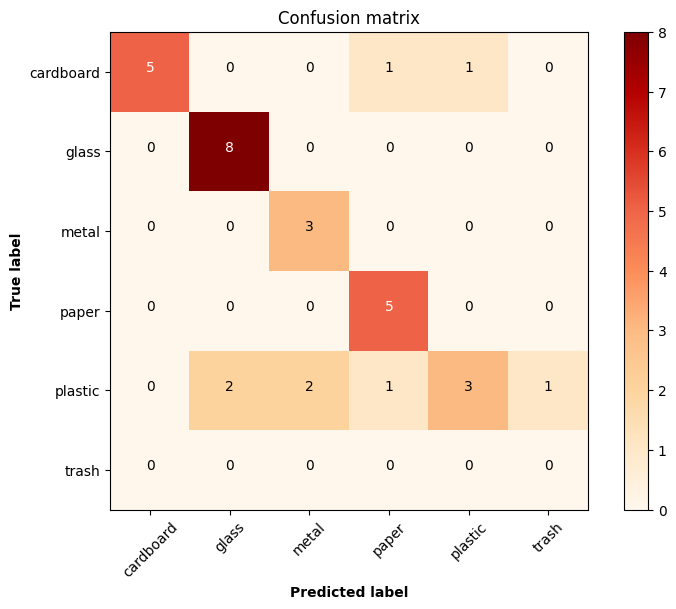

In [29]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title="Confusion matrix",
                      cmap=plt.cm.OrRd)